In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy import interpolate
import scipy.stats as stats

In [14]:
import os
import json
import scipy.optimize as optimize
class read_json_Suzuki_model_RWASM_T:
    
    def __init__(self,fh):
        if os.path.isfile(fh):
            self.file = fh
            self.data = json.load(open(fh))
        else:
            print('input file not in current directory')
            quit()
        
        self.model = self.data["model"]
        self.name = self.data["material"]
        # properties
        self.element_data = self.data['elements']
        # compositions
        self.elements_order = self.data['compositions']['element_order']
        self.concentrations = self.data['compositions']['concentrations']
        element_composition = {}
        for i in range(len(self.elements_order)):
            c_x = np.array(self.concentrations).transpose()[i]
            c_x_T = (np.ones((len(self.temperature_range),len(c_x)))*np.array(c_x)).transpose().flatten()
            element_composition[self.elements_order[i]] = c_x_T
        self.element_composition = pd.DataFrame(data=element_composition)
        # adjustable scalers
        self.adjustable_scalers = self.data['adjustables']
        # exp conditions
        self.experiment_conditions = self.data['conditions']
        # output file
        try: 
            self.savefilename = self.data['savefile']
        except:
            self.savefilename = self.data["material"] + '_out'
        

In [296]:
class Suzuki_model_RWASM_T:
    
    def __init__(self,
                element_data,
                experiment_conditions,
                adjustable_scalers):
        
        # 
        self.element_data = element_data
        # conditions
        self.strain_r = experiment_conditions['strain_r']
        self.T_range = np.arange(experiment_conditions['temperature']['min'],
                               experiment_conditions['temperature']['max']+experiment_conditions['temperature']['inc'],
                               experiment_conditions['temperature']['inc'])
        # constants
        self.boltzmann_J = 1.380649e-23
        self.boltzmann_eV = 8.617333262145e-5
        self.J2eV = self.boltzmann_eV/self.boltzmann_J
        self.eV2J = 1/self.J2eV
        self.Debye = 5 * 10**(12) # Debye frequency /s
        
        #adjustables
        self.rho = adjustable_scalers['dislocation_density']
        self.tau_i_exponent = adjustable_scalers['tau_i_exponent']
        self.trial_kappa_range = np.arange(adjustable_scalers['trial_kappa']['min'],
                                          adjustable_scalers['trial_kappa']['max']+adjustable_scalers['trial_kappa']['inc'],
                                          adjustable_scalers['trial_kappa']['inc'])
        self.trial_tau_k = adjustable_scalers['trial_tau_k'] * 1e6
        self.kink_width = adjustable_scalers['kink_width']
        
    def L(self,kappa_i):
        y = 1- stats.norm.cdf(kappa_i)
        return self.b/(3*y*self.c) 
    
    def tau_j(self,kappa_i):
        return (self.E_int + self.E_vac)/(4*self.b*self.L(kappa_i))
    
    def tau_y_k_j(self,tau_k_trial,kappa_i_list):
        
        self.Delta_V = lambda tau_k_trial,kappa_i: 3 * kappa_i**2 * self.E_w**2 * self.c / (2*tau_k_trial**2*self.a_p*self.b**2) + \
                                     tau_k_trial**2 * self.a_p**3 * self.b**4 * self.lambda_k**2 / (6*kappa_i**2 * self.E_w**2 * self.c)
        self.S = lambda tau_k_trial,kappa_i: 18 * kappa_i**2 * self.E_w**2 * self.c *self.kT /(self.a_p**3 * self.b**4 * self.lambda_k**2) * \
                 np.log( (5*np.pi*self.kT)**2 * self.Debye * self.a_p * self.b /((self.G*self.b*self.Delta_V(tau_k_trial,kappa_i))**2 * self.strain_r) )
        self.R = lambda kappa_i: 27 * kappa_i**4 * self.E_w**4 * self.c**2 / (self.a_p**4 * self.b**6 * self.lambda_k**2)
        # x[0] = tau_k_trial
        # x[1] = kappa_i
        self.tau_k_func = lambda tau_k_trial,kappa_i: tau_k_trial**4 + tau_k_trial*self.S(tau_k_trial,kappa_i) - self.R(kappa_i) 
        self.tau_k_kappa = []
        self.tau_j_kappa = []
        self.tau_y_kappa = []
        for kappa_i in kappa_i_list:
            self.res = optimize.root(self.tau_k_func, tau_k_trial, args=(kappa_i,))
            self.tau_k_kappa.append(self.res.x[0])
            self.tau_j_kappa.append(self.tau_j(kappa_i))
            self.tau_y_kappa.append(self.res.x[0] + self.tau_j(kappa_i))
        #print(self.tau_y_kappa)
        
    
    def phenomelogical_model_tau_y(self): 
        # tau_y = ( sum( tau_y_i**(1/q) ) )**q
        self.tau_y_tot = sum(self.tau_y_i**(1/self.tau_i_exponent))**self.tau_i_exponent
        
    def calculate(self):
        tau_y_tot_T = []
        tau_y_i_T_list = []
        tau_k_i_T_list = []
        tau_j_i_T_list = []
        self.elements_kappa_i_convergence_record = pd.DataFrame(data={})
        for element_symbol in self.element_data:
            self.elements_kappa_i_convergence_record[element_symbol] = {}
        for T in self.T_range:
            self.T = T
            self.kT = self.boltzmann_J * self.T
            # record tau_y for every element
            tau_y_i = []
            tau_k_i = []
            tau_j_i = []
            for element_symbol in self.element_data:
                element_i = self.element_data[element_symbol]
                #print(element_i)
                # calculate the yield strength contribution for every element
                # according to concentration
                # setup properties for every element
                self.E_f_v = element_i['E_f_v'] * self.eV2J #J
                self.E_f_si = element_i['E_f_si'] * self.eV2J # J
                self.a_0 = element_i['a']*1e-10#element_i['a_0'] * 10**(-10) # unit: m
                self.E_w = element_i['E_w'] * self.eV2J#element_i['E_w'] * self.eV2J # J
                self.c = element_i['c']
                self.G = element_i['G'] * 10**9 # Pa
                self.nu = element_i['nu']
                self.b = self.a_0 * np.sqrt(3) / 2
                self.a_p = self.a_0 * np.sqrt(2/3)
                #self.E_vac = 0.6 * self.eV2J / 10**(-10) # test NbTiZr
                #self.E_int = 0.9 * self.eV2J / 10**(-10) # test NbTiZr
                self.E_vac = 0.707 * self.E_f_v  /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                self.E_int = 0.707 * self.E_f_si /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
                self.lambda_k = self.b * self.kink_width
                
                # record the optimization results for post-processing
                tau_k_list = []
                tau_j_list = []
                tau_y_list = []
                optimized_kappa_list = []
                
                # start to optimize tau_k for every trial kappa

                self.tau_y_k_j(self.trial_tau_k, self.trial_kappa_range)
                tau_k_list = np.array(self.tau_k_kappa)/1e6
                tau_j_list = np.array(self.tau_j_kappa)/1e6
                tau_y_list = np.array(self.tau_y_kappa)/1e6
                kappa_list = self.trial_kappa_range
                
                # optimize tau_y over kappa, this finds the true tau_y for each element
                kappa_sort, tau_y_sort, tau_j_sort, tau_k_sort  = zip(*sorted(zip(kappa_list, tau_y_list, tau_j_list, tau_k_list)))
                ###
                polyfit = np.polyfit(kappa_sort,tau_y_sort,4)
                npfit = np.poly1d(polyfit)
                guess_kappa = (self.trial_kappa_range[0]+self.trial_kappa_range[1])/2
                res = optimize.fmin_slsqp(npfit,guess_kappa,
                                          bounds=([(self.trial_kappa_range[0],self.trial_kappa_range[-1])]),
                                          iprint=-1)
                optimized_kappa = res[0]
                tau_y_i.append(npfit(optimized_kappa))
                tau_k_i.append(npfit(optimized_kappa)-(self.tau_j(optimized_kappa)))
                tau_j_i.append(self.tau_j(optimized_kappa))
                
                # record for convergence check
                self.elements_kappa_i_convergence_record[element_symbol]['kappa_'+str(self.T)] = None # strange thing here, only by setting None it records the first row of data
                self.elements_kappa_i_convergence_record[element_symbol]['tau_y_'+str(self.T)] = None
                self.elements_kappa_i_convergence_record[element_symbol]['kappa_'+str(self.T)] = kappa_sort
                self.elements_kappa_i_convergence_record[element_symbol]['tau_y_'+str(self.T)] = tau_y_sort
                # tau_k_i, tau_j_i dont add up to tau_y_tot
            tau_y_i_T_list.append(tau_y_i)
            tau_k_i_T_list.append(tau_k_i)
            tau_j_i_T_list.append(tau_j_i)

            self.tau_y_i = np.array(tau_y_i)
            self.phenomelogical_model_tau_y()
            tau_y_tot_T.append(self.tau_y_tot)
        self.tau_y_tot_T = np.array(tau_y_tot_T)
        self.tau_y_i_T_list = np.array(tau_y_i_T_list).transpose()
        self.tau_k_i_T_list = np.array(tau_k_i_T_list).transpose()
        self.tau_j_i_T_list = np.array(tau_j_i_T_list).transpose()
    def writedata(self):
        self.calc_data = pd.DataFrame(data=
                                     {
                                         "T": self.T_range,
                                         "tau_y": np.round(self.tau_y_tot_T,2)
                                     })
        for i, element_symbol in zip(range(len(self.element_data)),self.element_data):
            self.calc_data["tau_y_"+str(element_symbol)] = np.round(self.tau_y_i_T_list[i],2)
            self.calc_data["tau_k_"+str(element_symbol)] = np.round(self.tau_k_i_T_list[i],2)
            self.calc_data["tau_j_"+str(element_symbol)] = np.round(self.tau_j_i_T_list[i],2)


In [298]:
input_data = read_json_Suzuki_model_RWASM_T('../sample_input_TiNbZr_BCC_screw_suzuki.json')

model = Suzuki_model_RWASM_T(input_data.element_data,
                            input_data.experiment_conditions,
                            input_data.adjustable_scalers)
model.calculate()
model.writedata()

KeyError: 'c'

(0, 1200)

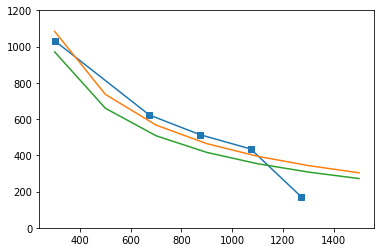

In [295]:
paper_data = [
1032.146606445312,
622.820007324219,
513.924377441406,
434.880462646484,
169.899871826172,
]
plt.plot([300,673,873,1073,1273],paper_data,'-s',label='paper')

plt.plot(model.T_range,np.array(model.tau_y_tot_T)*3.07)
plt.plot(model.T_range,np.array(model.tau_y_tot_T)*2.75)
plt.ylim(0,1200)

In [274]:
model.calc_data

,T,tau_y,tau_y_Nb,tau_k_Nb,tau_j_Nb,tau_y_Ti,tau_k_Ti,tau_j_Ti,tau_y_Zr,tau_k_Zr,tau_j_Zr
0,300,352.99,172.74,-31317508.80,31317681.54,58.30,-8418934.09,8418992.39,121.96,-22895799.60,22895921.56
1,500,239.84,117.74,-19664388.49,19664506.23,38.89,-3263441.69,3263480.58,83.21,-14683849.80,14683933.02
2,700,184.63,91.13,-13626641.38,13626732.51,28.97,-1630572.20,1630601.17,64.53,-10627463.19,10627527.72
3,900,151.28,75.02,-9618216.07,9618291.09,22.96,-1240883.03,1240905.99,53.30,-8072113.68,8072166.98
4,1100,128.58,63.94,-6566210.30,6566274.24,18.97,-1075109.53,1075128.50,45.67,-6218896.45,6218942.12
5,1300,111.86,55.66,-4335219.71,4335275.37,16.12,-982856.78,982872.90,40.07,-4742973.26,4743013.34
6,1500,98.87,49.16,-3116011.93,3116061.09,13.99,-923914.69,923928.67,35.73,-3521740.80,3521776.52


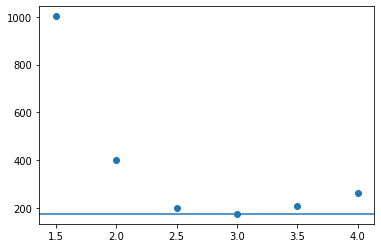

In [275]:
x = model.elements_kappa_i_convergence_record['Nb']['kappa_300']
y = model.elements_kappa_i_convergence_record['Nb']['tau_y_300']

plt.scatter(x,y)
#plt.ylim(0,500)
plt.axhline(min(y))

In [276]:
model.elements_kappa_i_convergence_record['Nb']

tau_y_300     (1002.7963064959441, 400.0525519821588, 199.74...
kappa_300                        (1.5, 2.0, 2.5, 3.0, 3.5, 4.0)
kappa_500                        (1.5, 2.0, 2.5, 3.0, 3.5, 4.0)
tau_y_500     (986.6387111576939, 372.551267326332, 158.2651...
kappa_700                        (1.5, 2.0, 2.5, 3.0, 3.5, 4.0)
tau_y_700     (979.4799040704661, 360.35709457371473, 139.82...
kappa_900                        (1.5, 2.0, 2.5, 3.0, 3.5, 4.0)
tau_y_900     (975.4115548666172, 353.430670741139, 129.3480...
kappa_1100                       (1.5, 2.0, 2.5, 3.0, 3.5, 4.0)
tau_y_1100    (972.7767502727976, 348.9473376281844, 122.569...
kappa_1300                       (1.5, 2.0, 2.5, 3.0, 3.5, 4.0)
tau_y_1300    (970.9261670420253, 345.79996959158024, 117.81...
kappa_1500                       (1.5, 2.0, 2.5, 3.0, 3.5, 4.0)
tau_y_1500    (969.5523184063393, 343.4644202311275, 114.284...
Name: Nb, dtype: object

In [277]:
model.elements_kappa_i_convergence_record['Nb'].to_dict()

{'tau_y_300': (1002.7963064959441,
  400.0525519821588,
  199.74675570484422,
  174.01974690565837,
  208.41596094955932,
  261.84029020880877),
 'kappa_300': (1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
 'kappa_500': (1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
 'tau_y_500': (986.6387111576939,
  372.551267326332,
  158.2651990579083,
  116.15019165354414,
  132.0480587829182,
  165.2428424906762),
 'kappa_700': (1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
 'tau_y_700': (979.4799040704661,
  360.35709457371473,
  139.82291829075095,
  90.29180524778124,
  97.65110180150738,
  121.23558650976634),
 'kappa_900': (1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
 'tau_y_900': (975.4115548666172,
  353.430670741139,
  129.34804125673517,
  75.59860513642636,
  78.08763468323951,
  96.16702681518166),
 'kappa_1100': (1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
 'tau_y_1100': (972.7767502727976,
  348.9473376281844,
  122.56999832808667,
  66.09214217949625,
  65.42928448393332,
  79.94234728521018),
 'kappa_1300': (1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
 'tau_y_1300

In [278]:
x = np.array(model.elements_kappa_i_convergence_record['Nb']['kappa_300'])
y = np.array(model.elements_kappa_i_convergence_record['Nb']['tau_y_300'])

In [279]:
y.min()

174.01974690565837

In [280]:
polyfit = np.polyfit(x,y,4)
npfit = np.poly1d(polyfit)
guess_kappa = 3
optimized_kappa = optimize.fmin_slsqp(npfit,guess_kappa,bounds=[(1,4)])

Optimization terminated successfully    (Exit mode 0)
            Current function value: [172.73632164]
            Iterations: 5
            Function evaluations: 11
            Gradient evaluations: 5


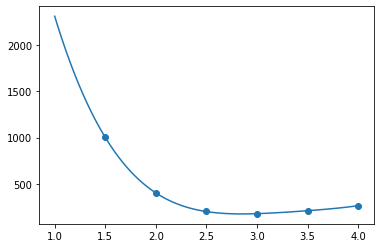

In [281]:
x_t = np.linspace(1,4,100)
plt.scatter(x,y)
plt.plot(x_t,npfit(x_t))